# Initialize

Import necessary packages and data

In [2]:
from pylab import *
import netCDF4
import numpy as np
import sys
from matplotlib import colors, ticker
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from scipy import stats
from scipy import signal
import pysal

In [3]:
data = netCDF4.Dataset( '../data/cm1out.nc', 'r', format='NETCDF4')

In [4]:
# Import variables of interest
X = array(data.variables['ni'])           # radial grid values
Z = array(data.variables['nk'])           # vertical grid values
rain_fall = array(data.variables['rain']) # suface accumulated rainfall
prs = array(data.variables['prs'])        # pressure (all vertical levels)
surf_prs = array(data.variables['sps'])   # surface pressure
DH = array(data.variables['th9'])         # radial grid values
U = array(data.variables['uinterp'])      # radial velocity
V = array(data.variables['vinterp'])      # tangential velocity
W = array(data.variables['winterp'])      # vertical velocity
time = array(data.variables['time'])      # time

In [5]:
# reshape 4-dim variable to 3-dim (t,z,x)
U_T = U.reshape(U.shape[0],U.shape[1],U.shape[3])
V_T = V.reshape(V.shape[0],V.shape[1],V.shape[3])
W_T = W.reshape(W.shape[0],W.shape[1],W.shape[3])
DH_T = DH.reshape(DH.shape[0],DH.shape[1],DH.shape[3])
prs_T = prs.reshape(prs.shape[0],prs.shape[1],prs.shape[3])
# reshape 3-dim to 2-dim
s_prs_T = surf_prs.reshape(surf_prs.shape[0],surf_prs.shape[2])
s_rain = rain_fall.reshape(rain_fall.shape[0],rain_fall.shape[2])

# change pressure to mb (millibars)
prs_mb = prs_T/100
s_prs_mb = s_prs_T/100

# Early Warning Signals for V$_{max}$
Reduce data

In [6]:
t_len = 480
t_win = 440

time_test = time[40:t_len]/1440

V_test = V_T[40:t_len,:,0:99]
V_test.shape

(440, 61, 99)

Temporal variance

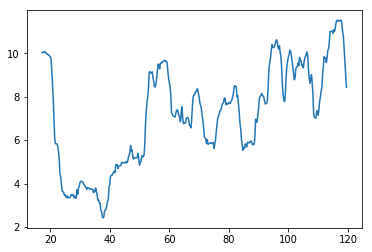

In [7]:
var_win = 30

V_max = np.amax(V_test, axis=(1,2))
V_tvar = np.empty(t_win-var_win)

for t in range(t_win-var_win):
    V_tvar[t] = np.std(V_max[t:t+var_win])
    
plt.plot(time_test[var_win-1:-1],V_tvar)

Changes in variance

(408,)

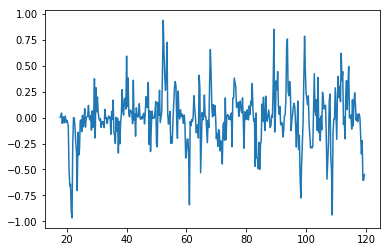

In [16]:
d_tvar = np.empty(t_win-1)
d_tvar = V_tvar[1:-1]-V_tvar[0:-2]
plt.plot(time_test[var_win+1:-1],d_tvar)

In [24]:
t_max = np.array([])
leng = d_tvar.shape[0]

for i in range(leng):
    if d_tvar[i] > 0.7:
        ti = time_test[var_win+1+i]
        t_max = np.append(t_max,ti)
        
print(t_max)

[52.25 53.5  89.25 93.75 99.5 ]


Spatial Variance of V_T

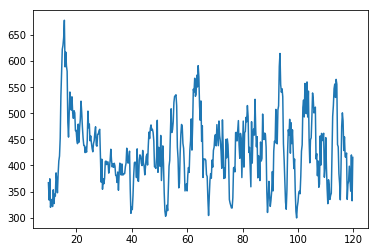

In [26]:
V_svar = np.var(V_test,axis=(1,2))
plt.plot(time_test,V_svar)

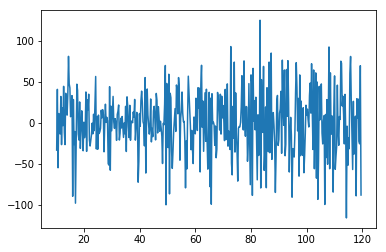

In [27]:
d_svar = np.empty(t_win-1)
d_svar = V_svar[1:-1]-V_svar[0:-2]
plt.plot(time_test[1:-1],d_svar)

In [32]:
s_max = np.array([])
leng = d_svar.shape[0]

for i in range(leng):
    if d_svar[i] > 60:
        si = time_test[1+i]
        s_max = np.append(s_max,si)
        
print(s_max)

[ 14.5   49.25  62.25  72.75  74.    77.5   80.75  83.25  84.5   86.5
  87.25  91.25  92.    92.75  93.25  96.25 101.75 102.5  103.25 108.
 108.5  112.25 112.5  115.5  115.75 119.25]


Autocorrelation of V$_{max}$ (lag = 6 hours)

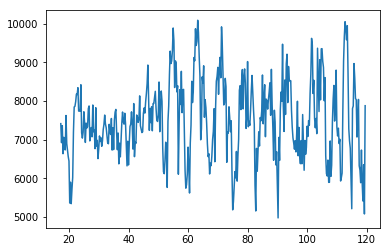

In [33]:
ac_win = 30
lag = 1

V_acorr = np.empty(t_win-ac_win)

for t in range(t_win-ac_win):
    corr_t = signal.correlate(V_max[t:t+ac_win],V_max[t+lag:t+ac_win+lag])
    V_acorr[t] = corr_t[0]
    
plt.plot(time_test[ac_win-1:-lag],V_acorr)

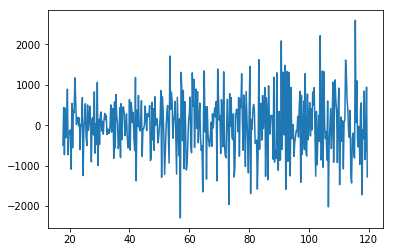

In [35]:
d_acor = np.empty(ac_win-1)
d_acor = V_acorr[1:-1]-V_acorr[0:-2]
plt.plot(time_test[var_win+1:-1],d_acor)

In [37]:
ac_max = np.array([])
leng = d_acor.shape[0]

for i in range(leng):
    if d_acor[i] > 1000:
        aci = time_test[1+i]
        ac_max = np.append(ac_max,aci)
        
print(ac_max)

[ 14.25  21.75  34.5   46.    49.75  53.5   54.    57.5   62.    64.
  70.    72.75  75.75  80.75  81.75  83.25  83.75  84.5   85.25  85.75
  91.25  96.25  97.    97.5  100.5  101.25 104.75 105.   108.   108.5 ]


Spatial correlation

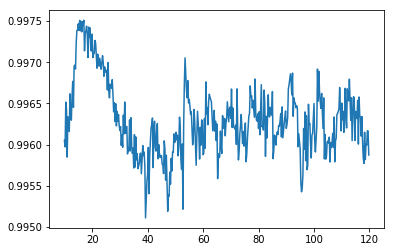

In [39]:
V_corr = np.empty(t_win)
w = pysal.lat2W(61,99)

for t in range(t_win):
    corr_t = pysal.Moran(V_test[t,:,:],w)
    V_corr[t] = corr_t.I
    
plt.plot(time_test,V_corr)

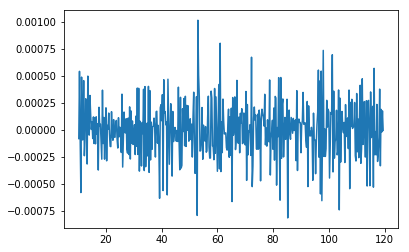

In [40]:
d_scor = np.empty(t_win-1)
d_scor = V_corr[1:-1]-V_corr[0:-2]
plt.plot(time_test[1:-1],d_scor)

In [41]:
sc_max = np.array([])
leng = d_scor.shape[0]

for i in range(leng):
    if d_scor[i] > 0.0006:
        sci = time_test[1+i]
        sc_max = np.append(sc_max,sci)
        
print(sc_max)

[ 53.    61.    72.25  98.   101.25]


Temporal Skewness

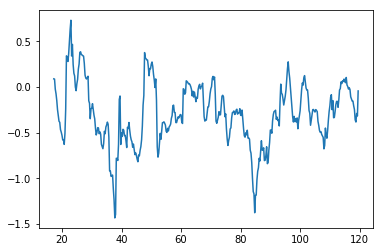

In [49]:
skw_win = 30

V_skw = np.empty(t_win-skw_win)

for t in range(t_win-skw_win):
    V_skw[t] = stats.skew(V_max[t:t+skw_win])
    
plt.plot(time_test[skw_win-1:-1],V_skw)

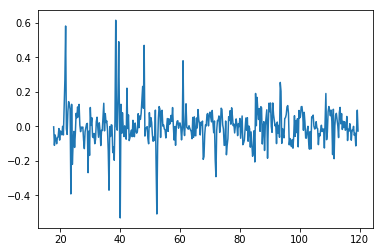

In [50]:
d_skw = np.empty(t_win-1)
d_skw  = V_skw[1:-1]-V_skw[0:-2]
plt.plot(time_test[skw_win+1:-1],d_skw)

In [51]:
skw_max = np.array([])
leng = d_skw.shape[0]

for i in range(leng):
    if d_skw[i] < -0.1:
        ski = time_test[1+i]
        skw_max = np.append(skw_max,ski)
        
print(skw_max)

[ 10.5   11.25  16.    16.5   17.25  20.5   21.75  22.25  24.    26.
  28.5   28.75  30.    30.25  30.5   32.5   42.    44.5   44.75  45.
  51.    60.25  60.5   64.25  64.5   67.25  67.5   68.    68.25  73.5
  76.    76.5   76.75  77.    77.5   80.    80.75  81.75  84.75  89.
  89.5   89.75  90.25  92.    95.75  96.25  98.75 100.75 103.5  104.
 111.25]
